In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy
from keras.layers.convolutional import Conv1D, MaxPooling1D

C:\Users\Docente\AppData\Local\Temp\ipykernel_4948\4143713903.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Carga de datos

In [3]:
df = pd.read_csv('../data/PERU_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 1995-03-01 to 2023-10-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  344 non-null    float64
 1   PD37976BM  344 non-null    float64
 2   PN02028AM  344 non-null    float64
 3   PD37972BM  344 non-null    float64
 4   PD37974BM  344 non-null    float64
 5   Class      344 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.8 KB


In [5]:
df.describe()

,PN02312FM,PD37976BM,PN02028AM,PD37972BM,PD37974BM,Class
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.006540,0.003332,0.002009,0.005400,0.002996,0.145349
std,0.009723,0.008992,0.006924,0.007266,0.013820,0.352966
min,-0.023125,-0.021834,-0.024268,-0.014352,-0.044618,0.000000
25%,-0.000013,-0.001842,-0.001570,0.000846,-0.004068,0.000000
50%,0.007247,0.003954,0.002133,0.006201,0.003270,0.000000
75%,0.011854,0.009464,0.006366,0.009691,0.010595,0.000000
max,0.041441,0.026307,0.026851,0.025603,0.035129,1.000000


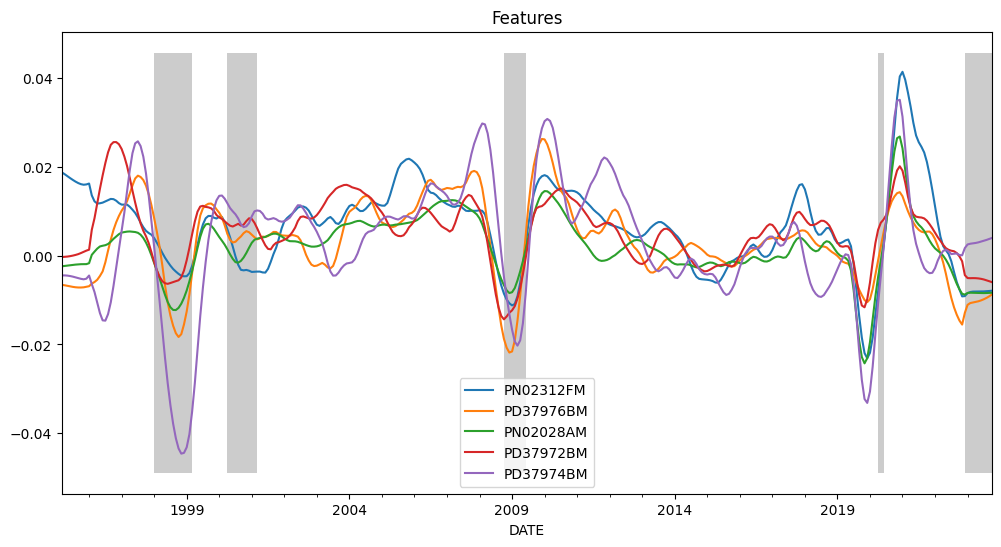

In [6]:
graficarTodo(df,'Features')

# Mostrar Imbalance de clases

In [7]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 344
    Positive: 50 (14.53% of total)



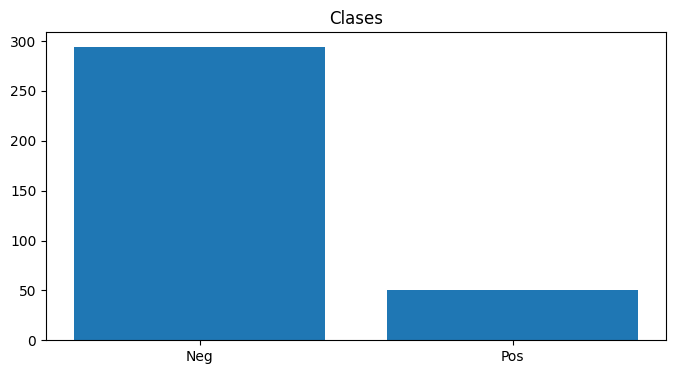

In [8]:
graficarClases(df['Class'])

In [9]:
initial_bias = np.log([pos/neg])

In [10]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.59
Weight for class 1: 3.44


# Dividir Datos

In [11]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.3)

# Normalizar

In [12]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

## Modelo

In [13]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_cnn(n_steps_in: int, n_features: int, conv1_kernels: int,
              conv1_kernel_size: int, conv1_dropout : float, conv2_kernels: int,
              conv2_kernel_size: int, conv2_dropout : float, dense_nodes: int, 
              dense_layers : int, dense_dropout : float, learning_rate: float, 
              conv_activation = None, dense_activation = None,
              metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = Constant(output_bias)
    model = Sequential()
    # Conv 1
    model.add(Conv1D(
        filters=conv1_kernels,
        kernel_size=conv1_kernel_size,
        activation=conv_activation, 
        padding = 'same',
        input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=conv1_kernel_size, padding='same'))
    model.add(Dropout(conv1_dropout))
    # Conv 2
    model.add(Conv1D(
        filters=conv2_kernels,
        kernel_size=conv2_kernel_size,
        activation=conv_activation, 
        padding = 'same'))
    model.add(MaxPooling1D(pool_size=conv2_kernel_size, padding='same'))
    model.add(Dropout(conv2_dropout))
    # Dense
    model.add(Flatten())
    for i in range(dense_layers):
        model.add(Dense(dense_nodes, activation=dense_activation))
    model.add(Dropout(dense_dropout))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=BinaryCrossentropy(), metrics=metrics)
    return model

## Optimizador

In [14]:
class CNNHyperModel(HyperModel):

    def __init__(self, n_features_in,n_steps_out, output_bias = None, class_weight= None, name = None, tunable = True):
        super().__init__(name=name, tunable=tunable)
        self.n_features = n_features_in
        self.n_steps_out = n_steps_out
        self.output_bias = output_bias
        self.class_weight = class_weight

    def build(self, hp):
        # Parametrizamos nro de capas, nro de nodos y ratio de aprendizaje
        hp_time_steps = hp.Int('steps_in',4,24,step=1)
        hp_conv1_kernels = hp.Int('conv1_kernels',32,356,step=16)
        hp_conv1_kernel_size = hp.Int('conv1_kernel_size',2,5,step=1)
        hp_conv1_dropout = hp.Float('conv1_dropout',0.1,0.5,step=0.1)
        hp_conv2_kernels = hp.Int('conv2_kernels',32,356,step=16)
        hp_conv2_kernel_size = hp.Int('conv2_kernel_size',2,5,step=1)
        hp_conv2_dropout = hp.Float('conv2_dropout',0.1,0.5,step=0.1)
        hp_dense_nodes = hp.Int('dense_nodes',32,356,step=16)
        hp_dense_layers = hp.Int('dense_layers',1,5,step=1)
        hp_dense_dropout = hp.Float('dense_dropout',0.1,0.5,step=0.1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
        hp_conv_activation = hp.Choice('conv_activation', values=['relu','tanh'])
        hp_dense_activation = hp.Choice('dense_activation', values=['relu','tanh'])

        return build_cnn(
            n_steps_in = hp_time_steps,
            n_features = self.n_features,
            conv1_kernels = hp_conv1_kernels,
            conv1_kernel_size = hp_conv1_kernel_size,
            conv1_dropout = hp_conv1_dropout,
            conv2_kernels = hp_conv2_kernels,
            conv2_kernel_size = hp_conv2_kernel_size,
            conv2_dropout = hp_conv2_dropout,
            dense_nodes = hp_dense_nodes,
            dense_layers = hp_dense_layers,
            dense_dropout = hp_dense_dropout,
            learning_rate = hp_learning_rate,
            conv_activation = hp_conv_activation,
            dense_activation = hp_dense_activation,
            output_bias = initial_bias
        )

    def fit(self, hp, model,x,y,**kwargs):
        x_s,y_s,_ = shift_data(x, y, hp.get('steps_in'), self.n_steps_out)
        #mini_batch = 32
        batch_learning = len(x_s)
        return model.fit(x = x_s, y = y_s, batch_size = batch_learning, class_weight=self.class_weight, **kwargs)

In [15]:
n_steps_out = [1,6,12]
n_features = len(features)
ajuste_path = os.path.normpath('G:/')
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
objective = kt.Objective('val_prc',direction='max')
max_epochs = 30
n_epochs = 1000

In [16]:
output_path = 'ajustes/'
output_path_model = 'modelos/'
name_prj = 'CNN_PERU_'
N = 20


In [17]:
def optimizar_y_entrenar(name_prj, n_steps_out):
    name_prj = name_prj + str(n_steps_out) +'_'+fecha_hora
    name_model_tun = output_path+name_prj+'.h5'
    # Condicion de parada: 10 epocas despues del menor val_loss
    es = EarlyStopping(
        monitor='val_prc', 
        verbose=0,
        patience=50,
        mode='max',
        restore_best_weights=True)
    
    # --------------------- Optimizacion --------------------------------------
    cnn_hypermodel = CNNHyperModel(n_features, n_steps_out, class_weight = class_weight) # output_bias=initial_bias

    cnn_tuner = kt.Hyperband(
        cnn_hypermodel,
        objective = objective,
        max_epochs = max_epochs,
        #directory = ajuste_path,
        project_name = name_prj,
        overwrite=True)

    print("Optimizando...")
    cnn_tuner.search(x = df_x_train, y = df_y_train, validation_split = 0.5, epochs = n_epochs
        , verbose = 2, shuffle = False, callbacks = [es])

    # guardar parametros de mejor modelo
    best_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials = 1)[0]
    print_hp(output_path+name_prj+'.txt',cnn_tuner)

    cnn_model = cnn_tuner.hypermodel.build(best_cnn_hps)
    cnn_model.save(name_model_tun) # modelo sin entrenar
    print(best_cnn_hps.values)

    # --------------------- Entrenamiento --------------------------------------
    n_steps_in = best_cnn_hps.get('steps_in')
    x_train, y_train,_ = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
    x_test, y_test,_ = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
    batch_learning = len(x_train)

    prcs = []
    models = []
    res_path = output_path_model+name_prj+".csv"
    print_line("loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc\n",res_path)
    print("Entrenando...")

    for i in range(N):
        name_model = output_path_model+name_prj+'_'+str(i)+'.h5'
        cnn_model = load_model(name_model_tun)
        # Condicion de parada: 10 epocas despues del menor val_loss
        es_t = EarlyStopping(
            monitor='val_prc', 
            verbose=0,
            patience=50,
            mode='max',
            restore_best_weights=True)
        models.append(name_model)
        history = cnn_model.fit(x=x_train, y=y_train, validation_split = 0.5, epochs = n_epochs
            , verbose = 0, shuffle = False, callbacks = [es_t], batch_size = batch_learning, class_weight=class_weight)

        cnn_model.save(name_model) 
        # --------------------- Evaluacion --------------------------------------
        res = cnn_model.evaluate(x_test, y_test,
                                        batch_size=batch_learning, verbose=0)
        print_line(f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]},{res[9]}\n', res_path)
        prcs.append(res[9]) #guarda metrica a comparar

    #--------- Evaluando el mejor ------------------------
    print("Evaluando...")
    best_model = models[np.argmax(prcs)]
    print(f'\nMejor modelo: {best_model} con prc: {np.max(prcs)}\n')
    for i in range(N):
        if i == np.argmax(prcs):
            continue
        os.remove(models[i])

    cnn_model = load_model(best_model)
    train_predictions = cnn_model(x_train) #, batch_size=batch_learning
    test_predictions = cnn_model(x_test)

    plot_cm(y_test, test_predictions)
    plot_roc(y_train, train_predictions, y_test, test_predictions)
    plot_prc(y_train, train_predictions, y_test, test_predictions)
    plot_probs(y_train, train_predictions, 'Train')
    plot_probs(y_test, test_predictions, 'Test')

# Modelo para 1 mes a futuro

Trial 90 Complete [00h 00m 07s]
val_prc: 0.529411792755127

Best val_prc So Far: 1.0000001192092896
Total elapsed time: 00h 04m 57s
{'steps_in': 4, 'conv1_kernels': 208, 'conv1_kernel_size': 2, 'conv1_dropout': 0.2, 'conv2_kernels': 256, 'conv2_kernel_size': 4, 'conv2_dropout': 0.30000000000000004, 'dense_nodes': 192, 'dense_layers': 5, 'dense_dropout': 0.2, 'learning_rate': 0.0001, 'conv_activation': 'relu', 'dense_activation': 'tanh', 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Entrenando...
Evaluando...

Mejor modelo: modelos/CNN_PERU_1_20240211_1834_2.h5 con prc: 0.488494873046875

Expansiones Detectadas (Verdadero Negativos):  79
Expansiones Incorrecas Detectadas (Falso Positivos):  6
Recesiones no Detectadas (False Negativos):  12
Recesiones Detectadas (Verdadero Positivos):  2
Total de Recesiones:  14


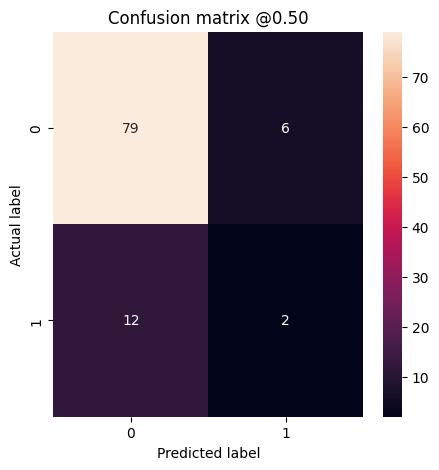

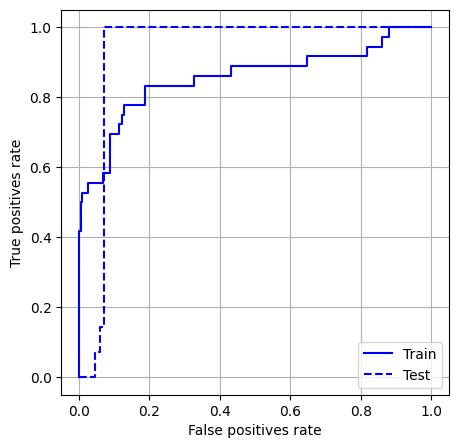

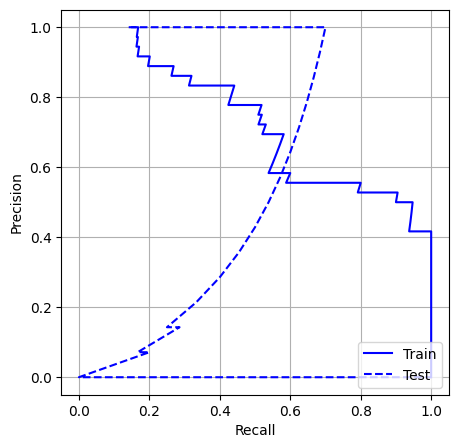

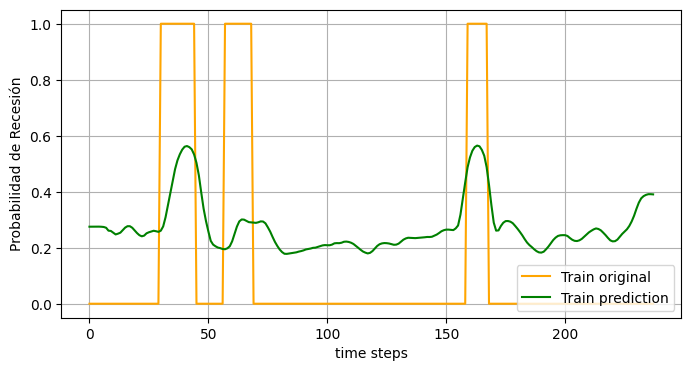

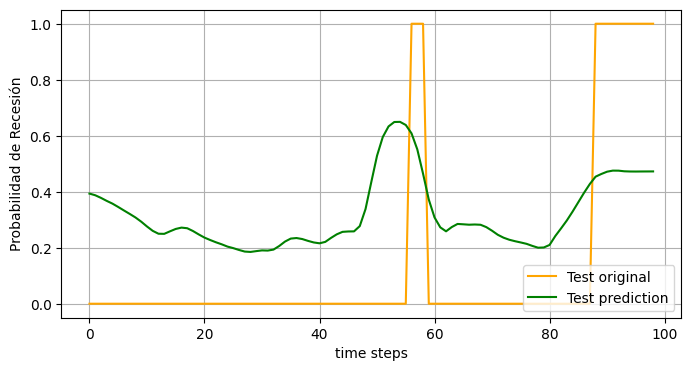

In [18]:
optimizar_y_entrenar(name_prj, n_steps_out[0])

# Modelo para 6 meses a futuro

Trial 90 Complete [00h 00m 06s]
val_prc: 0.2525039315223694

Best val_prc So Far: 0.9636484384536743
Total elapsed time: 00h 05m 02s
{'steps_in': 4, 'conv1_kernels': 48, 'conv1_kernel_size': 4, 'conv1_dropout': 0.2, 'conv2_kernels': 96, 'conv2_kernel_size': 2, 'conv2_dropout': 0.5, 'dense_nodes': 80, 'dense_layers': 3, 'dense_dropout': 0.4, 'learning_rate': 0.001, 'conv_activation': 'tanh', 'dense_activation': 'tanh', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0077'}
Entrenando...
Evaluando...

Mejor modelo: modelos/CNN_PERU_6_20240211_1834_7.h5 con prc: 0.44603174924850464

Expansiones Detectadas (Verdadero Negativos):  27
Expansiones Incorrecas Detectadas (Falso Positivos):  53
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  14
Total de Recesiones:  14


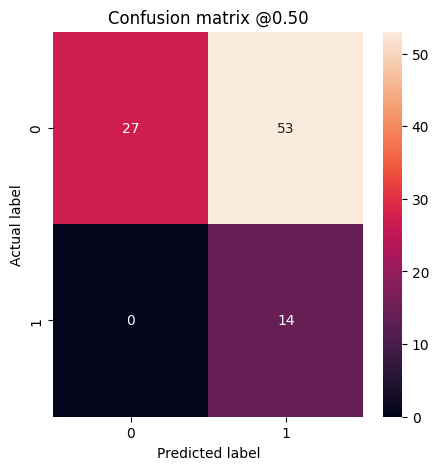

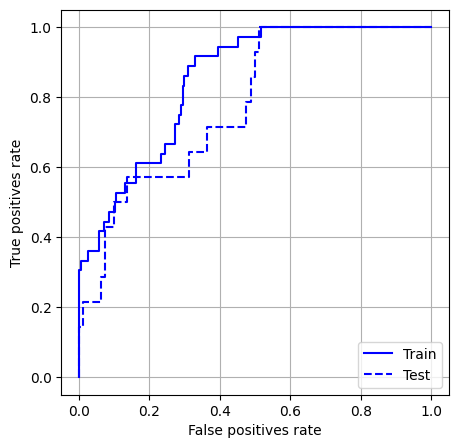

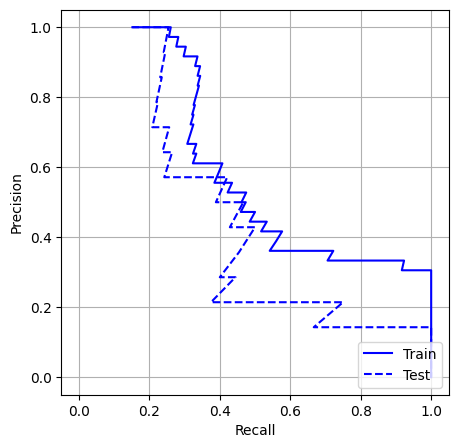

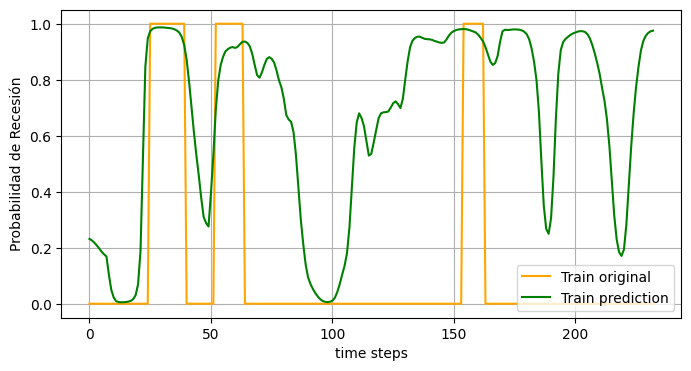

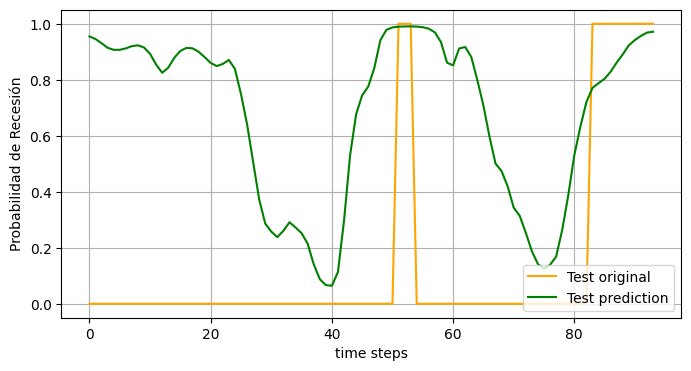

In [19]:
optimizar_y_entrenar(name_prj, n_steps_out[1])

# Modelo para 12 meses a futuro

Trial 90 Complete [00h 00m 19s]
val_prc: 0.12803667783737183

Best val_prc So Far: 0.7171205282211304
Total elapsed time: 00h 10m 59s
{'steps_in': 24, 'conv1_kernels': 192, 'conv1_kernel_size': 5, 'conv1_dropout': 0.4, 'conv2_kernels': 288, 'conv2_kernel_size': 2, 'conv2_dropout': 0.4, 'dense_nodes': 208, 'dense_layers': 5, 'dense_dropout': 0.5, 'learning_rate': 0.01, 'conv_activation': 'tanh', 'dense_activation': 'relu', 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Entrenando...


c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
c:\Users\Docente\Documents\Alegre\crisis-forecasting\modelamiento\../libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Evaluando...

Mejor modelo: modelos/CNN_PERU_12_20240211_1834_14.h5 con prc: 0.3481528162956238

Expansiones Detectadas (Verdadero Negativos):  54
Expansiones Incorrecas Detectadas (Falso Positivos):  0
Recesiones no Detectadas (False Negativos):  14
Recesiones Detectadas (Verdadero Positivos):  0
Total de Recesiones:  14


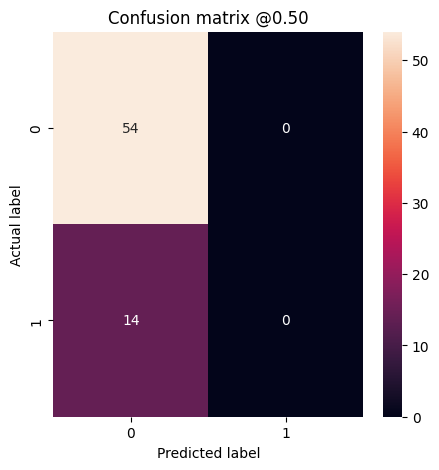

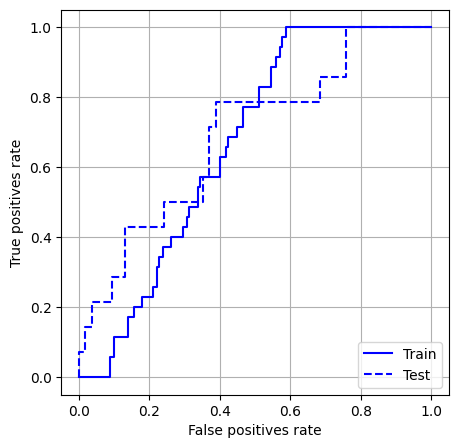

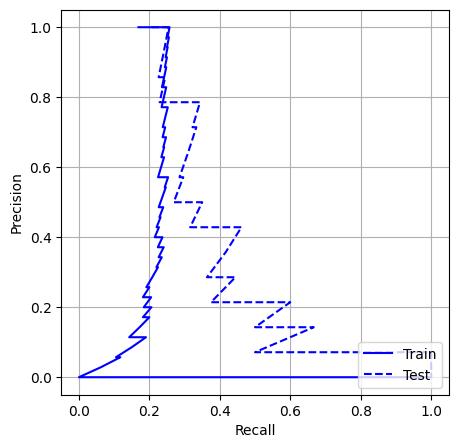

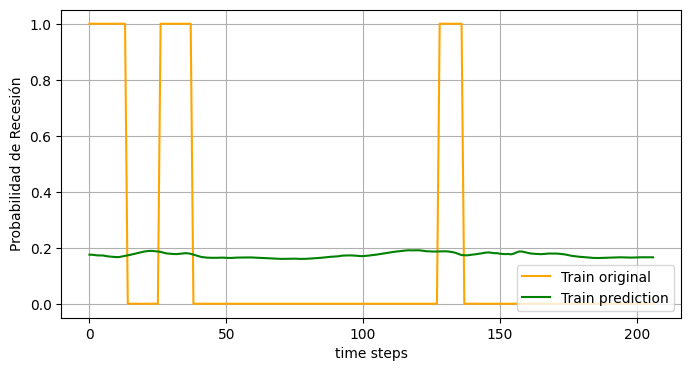

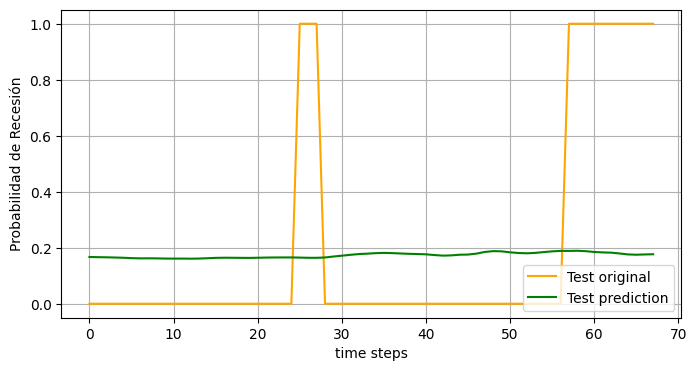

In [20]:
optimizar_y_entrenar(name_prj, n_steps_out[2])

In [21]:
from notifications import enviar_correo
subject = 'CNN_PERU hyper finish'
msg = 'Termino la evaluacion'
enviar_correo(subject=subject, msg=msg)